In [1]:
import numpy as np
import torch
import torchvision
from torch import nn, optim
from torch.nn import functional as F
from torch.autograd import Variable
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
import torchvision.models as models

In [2]:
batch_size_train = 100
batch_size_test = 100
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [3]:
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.CIFAR100('cifar100', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.CIFAR100('cifar100', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

100%|██████████| 169001437/169001437 [00:02<00:00, 74558367.93it/s]


Extracting cifar100/cifar-100-python.tar.gz to cifar100
Files already downloaded and verified


In [4]:
class Resnet34(nn.Module):
    def __init__(self):
        super(Resnet34, self).__init__() # Load pre-trained ResNet50 model
        self.resnet = models.resnet34(pretrained=False) # Modify the last layer for our classification task
        num_ftrs = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(num_ftrs, 100)
    def forward(self, x):
        x = self.resnet(x)
        return x

In [ ]:
model = Resnet34().to(device)
print(model)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Resnet34(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_run

In [ ]:
test_loss_min = np.Inf
LR=5e-4
optimizer = optim.Adam(model.parameters(), lr=LR)
test_acc_max = -100
history = {'train_loss': [], 'valid_loss': [], 'train_acc': [], 'valid_acc': []}
for epoch in range(1, 10):
    print(f'Epoch {epoch} ...')
    # keep track of training and test loss
    train_loss = 0.0
    test_loss = 0.0
    train_correct = 0
    test_correct = 0
    train_total = 0
    test_total = 0
    #Changing the optimizer setting while training
    if epoch % 5 ==0:
      LR=LR*0.94
      optimizer = optim.Adam(model.parameters(), lr=LR)

    model.train()
    for data, target in tqdm(train_loader):
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()*data.size(0)
        # update training accuracy
        _, predicted = torch.max(output.data, 1)
        train_total += target.size(0)
        train_correct += (predicted == target).sum().item()

    #validate
    model.eval()
    for data, target in tqdm(test_loader):
        # move tensors to GPU
        data, target = data.cuda(), target.cuda()
        # forward pass
        output = model(data)

        loss = F.cross_entropy(output, target)
        # update average validation loss
        test_loss += loss.item()*data.size(0)
        # update validation accuracy
        _, predicted = torch.max(output.data, 1)
        test_total += target.size(0)
        test_correct += (predicted == target).sum().item()

    # calculate average losses and accuracy
    train_loss = train_loss/len(train_loader.dataset)
    test_loss = test_loss/len(test_loader.dataset)
    train_acc = 100 * train_correct / train_total
    test_acc = 100 * test_correct / test_total

    # print training/validation statistics
    print('Epoch: {} \tTraining Loss: {:.6f} - Testing Loss: {:.6f} - Training Accuracy: {:.2f}% - Testing Accuracy: {:.2f}%'.format(
        epoch+1, train_loss, test_loss, train_acc, test_acc))

    # save model if validation loss has decreased
    if test_loss <= test_loss_min:
        print('Testing loss decreased ({:.6f} --> {:.6f}). The new model saved.'.format(test_loss_min, test_loss))
        torch.save(model.state_dict(), 'CIFAR100_Normal_ResNet_leastLoss.pt')
        test_loss_min = test_loss
    if test_acc >= test_acc_max:
        print('Testing Acc increased ({:.6f} --> {:.6f}). The new model saved.'.format(test_acc_max, test_acc))
        torch.save(model.state_dict(), 'CIFAR100_Normal_ResNet_Most_Accuracy.pt')
        test_acc_max = test_acc
    history['train_loss'].append(train_loss)
    history['valid_loss'].append(test_loss)
    history['train_acc'].append(train_acc)
    history['valid_acc'].append(test_acc)

Epoch 1 ...


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 2 	Training Loss: 3.661648 - Testing Loss: 3.647600 - Training Accuracy: 14.36% - Testing Accuracy: 16.76%
Testing loss decreased (inf --> 3.647600). The new model saved.
Testing Acc increased (-100.000000 --> 16.760000). The new model saved.
Epoch 2 ...


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 3 	Training Loss: 2.927093 - Testing Loss: 3.122435 - Training Accuracy: 26.42% - Testing Accuracy: 23.77%
Testing loss decreased (3.647600 --> 3.122435). The new model saved.
Testing Acc increased (16.760000 --> 23.770000). The new model saved.
Epoch 3 ...


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 4 	Training Loss: 2.525360 - Testing Loss: 2.869529 - Training Accuracy: 34.63% - Testing Accuracy: 28.28%
Testing loss decreased (3.122435 --> 2.869529). The new model saved.
Testing Acc increased (23.770000 --> 28.280000). The new model saved.
Epoch 4 ...


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 5 	Training Loss: 2.242646 - Testing Loss: 2.531302 - Training Accuracy: 40.53% - Testing Accuracy: 35.05%
Testing loss decreased (2.869529 --> 2.531302). The new model saved.
Testing Acc increased (28.280000 --> 35.050000). The new model saved.
Epoch 5 ...


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 6 	Training Loss: 2.009725 - Testing Loss: 2.595330 - Training Accuracy: 45.53% - Testing Accuracy: 35.34%
Testing Acc increased (35.050000 --> 35.340000). The new model saved.
Epoch 6 ...


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 7 	Training Loss: 1.757985 - Testing Loss: 2.482937 - Training Accuracy: 51.32% - Testing Accuracy: 38.94%
Testing loss decreased (2.531302 --> 2.482937). The new model saved.
Testing Acc increased (35.340000 --> 38.940000). The new model saved.
Epoch 7 ...


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 8 	Training Loss: 1.534046 - Testing Loss: 2.441329 - Training Accuracy: 56.67% - Testing Accuracy: 39.90%
Testing loss decreased (2.482937 --> 2.441329). The new model saved.
Testing Acc increased (38.940000 --> 39.900000). The new model saved.
Epoch 8 ...


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 9 	Training Loss: 1.315087 - Testing Loss: 2.503776 - Training Accuracy: 61.74% - Testing Accuracy: 40.86%
Testing Acc increased (39.900000 --> 40.860000). The new model saved.
Epoch 9 ...


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 10 	Training Loss: 1.099414 - Testing Loss: 2.624837 - Training Accuracy: 67.56% - Testing Accuracy: 39.79%


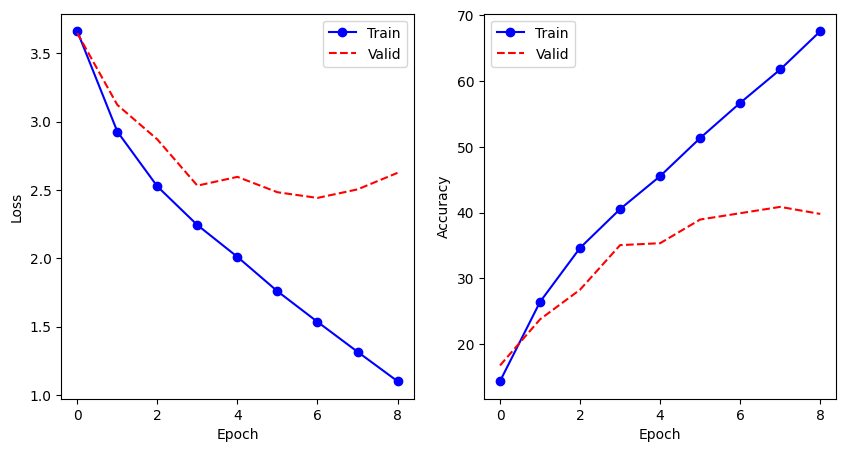

In [ ]:
import matplotlib.pyplot as plt
fig=plt.figure(1,figsize=(10,5))

plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], 'bo-', label='Train')
plt.plot(history['valid_loss'], 'r--', label='Valid')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], 'bo-', label='Train')
plt.plot(history['valid_acc'], 'r--', label='Valid')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

In [5]:
modelSynScaL = Resnet34().cuda()
test_loss_min_SynScaL = np.Inf
LR=5e-4
optimizer = optim.Adam(modelSynScaL.parameters(), lr=LR)
test_acc_max_SynScaL = -100
historySynScaL = {'train_loss': [], 'valid_loss': [], 'train_acc': [], 'valid_acc': []}
for epoch in range(1, 10):
    print(f'Epoch {epoch} ...')
    # keep track of training and test loss
    train_loss = 0.0
    test_loss = 0.0
    train_correct = 0
    test_correct = 0
    train_total = 0
    test_total = 0
    #Changing the optimizer setting while training
    if epoch % 5 ==0:
      LR=LR*0.94
      optimizer = optim.Adam(modelSynScaL.parameters(), lr=LR)

    modelSynScaL.train()
    for data, target in tqdm(train_loader):
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output = modelSynScaL(data)

        loss = F.cross_entropy(output, target)+ 1.0 * (0.01 - output.mean())**2
        loss.backward()
        optimizer.step()

        train_loss += loss.item()*data.size(0)
        # update training accuracy
        _, predicted = torch.max(output.data, 1)
        train_total += target.size(0)
        train_correct += (predicted == target).sum().item()

    #validate
    modelSynScaL.eval()
    for data, target in tqdm(test_loader):
        # move tensors to GPU
        data, target = data.cuda(), target.cuda()
        # forward pass
        output = modelSynScaL(data)

        loss = F.cross_entropy(output, target) +  1.0 * (0.1 - output.mean())**2
        # update average validation loss
        test_loss += loss.item()*data.size(0)
        # update validation accuracy
        _, predicted = torch.max(output.data, 1)
        test_total += target.size(0)
        test_correct += (predicted == target).sum().item()

    # calculate average losses and accuracy
    train_loss = train_loss/len(train_loader.dataset)
    test_loss = test_loss/len(test_loader.dataset)
    train_acc = 100 * train_correct / train_total
    test_acc = 100 * test_correct / test_total

    # print training/validation statistics
    print('Epoch: {} \tTraining Loss: {:.6f} - Testing Loss: {:.6f} - Training Accuracy: {:.2f}% - Testing Accuracy: {:.2f}%'.format(
        epoch+1, train_loss, test_loss, train_acc, test_acc))

    # save model if validation loss has decreased
    if test_loss <= test_loss_min_SynScaL:
        print('Testing loss decreased ({:.6f} --> {:.6f}). The new model saved.'.format(test_loss_min_SynScaL, test_loss))
        torch.save(modelSynScaL.state_dict(), 'CIFAR100_SynScaL_ResNet_leastLoss.pt')
        test_loss_min_SynScaL = test_loss
    if test_acc >= test_acc_max_SynScaL:
        print('Testing Acc increased ({:.6f} --> {:.6f}). The new model saved.'.format(test_acc_max_SynScaL, test_acc))
        torch.save(modelSynScaL.state_dict(), 'CIFAR100_SynScaL_ResNet_Most_Accuracy.pt')
        test_acc_max_SynScaL = test_acc
    historySynScaL['train_loss'].append(train_loss)
    historySynScaL['valid_loss'].append(test_loss)
    historySynScaL['train_acc'].append(train_acc)
    historySynScaL['valid_acc'].append(test_acc)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch 1 ...


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 2 	Training Loss: 3.687834 - Testing Loss: 3.337690 - Training Accuracy: 13.86% - Testing Accuracy: 19.25%
Testing loss decreased (inf --> 3.337690). The new model saved.
Testing Acc increased (-100.000000 --> 19.250000). The new model saved.
Epoch 2 ...


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 3 	Training Loss: 2.962606 - Testing Loss: 3.056291 - Training Accuracy: 25.74% - Testing Accuracy: 25.61%
Testing loss decreased (3.337690 --> 3.056291). The new model saved.
Testing Acc increased (19.250000 --> 25.610000). The new model saved.
Epoch 3 ...


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 4 	Training Loss: 2.562801 - Testing Loss: 2.729719 - Training Accuracy: 33.69% - Testing Accuracy: 30.79%
Testing loss decreased (3.056291 --> 2.729719). The new model saved.
Testing Acc increased (25.610000 --> 30.790000). The new model saved.
Epoch 4 ...


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 5 	Training Loss: 2.277233 - Testing Loss: 2.714224 - Training Accuracy: 39.78% - Testing Accuracy: 31.84%
Testing loss decreased (2.729719 --> 2.714224). The new model saved.
Testing Acc increased (30.790000 --> 31.840000). The new model saved.
Epoch 5 ...


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 6 	Training Loss: 2.060694 - Testing Loss: 3.325935 - Training Accuracy: 44.71% - Testing Accuracy: 27.56%
Epoch 6 ...


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 7 	Training Loss: 1.791481 - Testing Loss: 2.404596 - Training Accuracy: 50.63% - Testing Accuracy: 39.62%
Testing loss decreased (2.714224 --> 2.404596). The new model saved.
Testing Acc increased (31.840000 --> 39.620000). The new model saved.
Epoch 7 ...


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 8 	Training Loss: 1.560020 - Testing Loss: 2.486989 - Training Accuracy: 55.94% - Testing Accuracy: 39.57%
Epoch 8 ...


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 9 	Training Loss: 1.332707 - Testing Loss: 2.592650 - Training Accuracy: 61.72% - Testing Accuracy: 37.62%
Epoch 9 ...


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 10 	Training Loss: 1.118912 - Testing Loss: 2.617667 - Training Accuracy: 67.14% - Testing Accuracy: 40.38%
Testing Acc increased (39.620000 --> 40.380000). The new model saved.


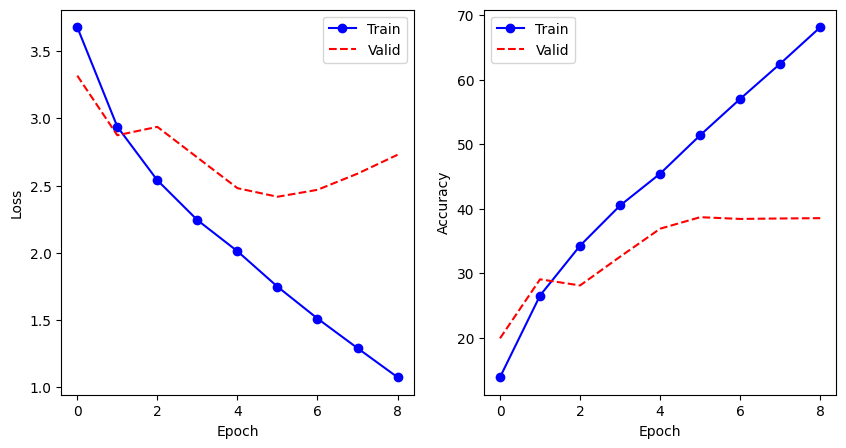

In [ ]:
fig=plt.figure(1,figsize=(10,5))
plt.subplot(1, 2, 1)
plt.plot(historySynScaL['train_loss'], 'bo-', label='Train')
plt.plot(historySynScaL['valid_loss'], 'r--', label='Valid')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(historySynScaL['train_acc'], 'bo-', label='Train')
plt.plot(historySynScaL['valid_acc'], 'r--', label='Valid')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

In [ ]:
def update_param(parameter_data, activation, gamma=0.1,mean = 0.1):
    activation = activation.data.numpy().mean(axis=(0)).squeeze()[:,None]
    param = parameter_data.numpy()
    new_param = param+gamma*np.clip((param*param)*(mean - activation).mean(),-1,1)
    return torch.from_numpy(new_param)
def perform_update(m):
    if type(m) == nn.Linear:
        m.eval()
        im = np.random.uniform(-1, 1, (100, m.in_features))+0.1
        im_as_ten = torch.from_numpy(im).float().cuda()
        x = Variable(im_as_ten, requires_grad=True)
        x = F.relu(m(x))
        m.weight.data = update_param(m.weight.data.cpu(),activation=x.cpu()).cuda()
    if type(m) == nn.Conv2d:
        m.eval()
        im = np.random.uniform(-1, 1, (100, m.weight.size()[1],28,28))+0.1
        im_as_ten = torch.from_numpy(im).float().cuda()
        x = Variable(im_as_ten, requires_grad=True)
        x = F.relu(m(x))
        m.weight.data = update_param(m.weight.data.cpu(),activation=x.cpu()).cuda()

In [ ]:
modelSynScaW = Resnet34().cuda()
test_loss_min_SynScaW= np.Inf
test_acc_max_SynScaW = -100
LR=5e-4
optimizer = optim.Adam(modelSynScaW.parameters(), lr=LR)
historySynScaW = {'train_loss': [], 'valid_loss': [], 'train_acc': [], 'valid_acc': []}
for epoch in range(1, 10):
    print(f'Epoch {epoch} ...')
    # keep track of training and test loss
    train_loss = 0.0
    test_loss = 0.0
    train_correct = 0
    test_correct = 0
    train_total = 0
    test_total = 0
    #Changing the optimizer setting while training
    if epoch % 5 ==0:
      LR=LR*0.94
      optimizer = optim.Adam(modelSynScaW.parameters(), lr=LR)

    modelSynScaW.train()
    for data, target in tqdm(train_loader):
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output = modelSynScaW(data)

        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()*data.size(0)
        # update training accuracy
        _, predicted = torch.max(output.data, 1)
        train_total += target.size(0)
        train_correct += (predicted == target).sum().item()
    modelSynScaW.apply(perform_update)
    #validate
    modelSynScaW.eval()
    for data, target in tqdm(test_loader):
        # move tensors to GPU
        data, target = data.cuda(), target.cuda()
        # forward pass
        output = modelSynScaW(data)

        loss = F.cross_entropy(output, target)
        # update average validation loss
        test_loss += loss.item()*data.size(0)
        # update validation accuracy
        _, predicted = torch.max(output.data, 1)
        test_total += target.size(0)
        test_correct += (predicted == target).sum().item()

    # calculate average losses and accuracy
    train_loss = train_loss/len(train_loader.dataset)
    test_loss = test_loss/len(test_loader.dataset)
    train_acc = 100 * train_correct / train_total
    test_acc = 100 * test_correct / test_total

    # print training/validation statistics
    print('Epoch: {} \tTraining Loss: {:.6f} - Testing Loss: {:.6f} - Training Accuracy: {:.2f}% - Testing Accuracy: {:.2f}%'.format(
        epoch+1, train_loss, test_loss, train_acc, test_acc))

    # save model if validation loss has decreased
    if test_loss <= test_loss_min_SynScaW:
        print('Testing loss decreased ({:.6f} --> {:.6f}). The new model saved.'.format(test_loss_min_SynScaW, test_loss))
        torch.save(modelSynScaW.state_dict(), 'CIFAR100_SynScaW_ResNet_leastLoss.pt')
        test_loss_min_SynScaW = test_loss
    if test_acc >= test_acc_max_SynScaW:
        print('Testing Acc increased ({:.6f} --> {:.6f}). The new model saved.'.format(test_acc_max_SynScaW, test_acc))
        torch.save(modelSynScaW.state_dict(), 'CIFAR100_SynScaW_ResNet_Most_Accuracy.pt')
        test_acc_max_SynScaW = test_acc
    historySynScaW['train_loss'].append(train_loss)
    historySynScaW['valid_loss'].append(test_loss)
    historySynScaW['train_acc'].append(train_acc)
    historySynScaW['valid_acc'].append(test_acc)

Epoch 1 ...


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 2 	Training Loss: 3.682900 - Testing Loss: 3.347002 - Training Accuracy: 13.93% - Testing Accuracy: 18.73%
Testing loss decreased (inf --> 3.347002). The new model saved.
Testing Acc increased (-100.000000 --> 18.730000). The new model saved.
Epoch 2 ...


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 3 	Training Loss: 2.966219 - Testing Loss: 2.951415 - Training Accuracy: 25.71% - Testing Accuracy: 26.74%
Testing loss decreased (3.347002 --> 2.951415). The new model saved.
Testing Acc increased (18.730000 --> 26.740000). The new model saved.
Epoch 3 ...


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 4 	Training Loss: 2.566942 - Testing Loss: 3.014390 - Training Accuracy: 33.55% - Testing Accuracy: 27.48%
Testing Acc increased (26.740000 --> 27.480000). The new model saved.
Epoch 4 ...


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 5 	Training Loss: 2.271824 - Testing Loss: 2.591965 - Training Accuracy: 39.88% - Testing Accuracy: 33.52%
Testing loss decreased (2.951415 --> 2.591965). The new model saved.
Testing Acc increased (27.480000 --> 33.520000). The new model saved.
Epoch 5 ...


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 6 	Training Loss: 2.045696 - Testing Loss: 2.525999 - Training Accuracy: 44.98% - Testing Accuracy: 35.40%
Testing loss decreased (2.591965 --> 2.525999). The new model saved.
Testing Acc increased (33.520000 --> 35.400000). The new model saved.
Epoch 6 ...


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 7 	Training Loss: 1.770917 - Testing Loss: 2.517207 - Training Accuracy: 51.15% - Testing Accuracy: 37.56%
Testing loss decreased (2.525999 --> 2.517207). The new model saved.
Testing Acc increased (35.400000 --> 37.560000). The new model saved.
Epoch 7 ...


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 8 	Training Loss: 1.541562 - Testing Loss: 2.453649 - Training Accuracy: 56.62% - Testing Accuracy: 38.44%
Testing loss decreased (2.517207 --> 2.453649). The new model saved.
Testing Acc increased (37.560000 --> 38.440000). The new model saved.
Epoch 8 ...


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 9 	Training Loss: 1.322642 - Testing Loss: 2.430872 - Training Accuracy: 61.87% - Testing Accuracy: 40.50%
Testing loss decreased (2.453649 --> 2.430872). The new model saved.
Testing Acc increased (38.440000 --> 40.500000). The new model saved.
Epoch 9 ...


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 10 	Training Loss: 1.101564 - Testing Loss: 2.419692 - Training Accuracy: 67.20% - Testing Accuracy: 41.39%
Testing loss decreased (2.430872 --> 2.419692). The new model saved.
Testing Acc increased (40.500000 --> 41.390000). The new model saved.


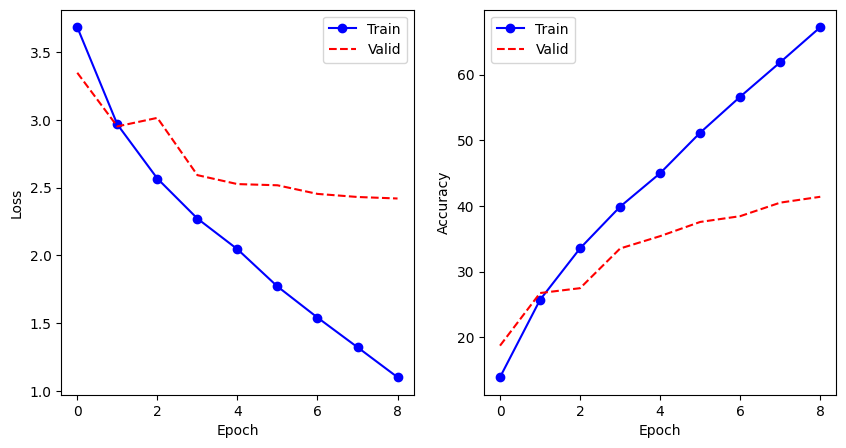

In [ ]:

import matplotlib.pyplot as plt
fig=plt.figure(1,figsize=(10,5))

plt.subplot(1, 2, 1)
plt.plot(historySynScaW['train_loss'], 'bo-', label='Train')
plt.plot(historySynScaW['valid_loss'], 'r--', label='Valid')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(historySynScaW['train_acc'], 'bo-', label='Train')
plt.plot(historySynScaW['valid_acc'], 'r--', label='Valid')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

In [7]:
from tabulate import tabulate
data = [['Loss', test_loss_min, test_loss_min_SynScaL, test_loss_min_SynScaW],
['Accuracy', test_acc_max, test_acc_max_SynScaL, test_acc_max_SynScaW],
]
print (tabulate(data, headers=["Type", "Normal", "SynScaL", "SynScaW"]))

Type        Normal    SynScaL    SynScaW
--------  --------  ---------  ---------
Loss       2.44133     2.4046    2.41969
Accuracy  40.86       40.38     41.39
